In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
from google.colab import files
from PIL import Image
import glob
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Conv2D,Input, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical, plot_model

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
tf.__version__

'2.15.0'

In [4]:
# @title Download Dataset from Kaggle (A kaggle.json should be downloaded by your Kaggle's account)
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d subhranilsarkar/alzheimer-s-disease-neuroimaging-adni-dataset
!unzip -q alzheimer-s-disease-neuroimaging-adni-dataset.zip

Upload kaggle.json account information to download the dataset:


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/subhranilsarkar/alzheimer-s-disease-neuroimaging-adni-dataset
License(s): CC-BY-NC-SA-4.0
 73% 9.00M/12.3M [00:00<00:00, 17.1MB/s]
100% 12.3M/12.3M [00:00<00:00, 22.9MB/s]


In [5]:
base_directory = '/content/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/'

# Define sub-directories for training, validation, and testing data
sub_directories = ['AD/', 'MCI/']

# Get a list of classes (sub-directories) inside the 'train/' directory
for sub_dir in sub_directories:
  dir = os.path.join(base_directory, sub_dir)
  print(dir)
# classes = os.listdir(
#     os.path.join(base_directory, sub_directories[0])
# )

# print(( os.path.join(base_directory, sub_directories[0])))

/content/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD/
/content/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI/


# ***Data augmentation***

In [6]:
# Define the data generator with augmentation parameters
data_generator = ImageDataGenerator(
    horizontal_flip=True,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    channel_shift_range=0.1,
    rotation_range=15,
    zoom_range=0.0
)


In [32]:
X = []
y = []
w = 64
h = 64
# Loop through the sub-directories (train, val, test)
for c in range(len(sub_directories)):
  dir = os.path.join(base_directory, sub_directories[c])
  images = glob.glob(dir + "*.jpg")
  # print(images)
  for img in images:
    image = cv2.imread(img)
    image = cv2.resize(image, (w, h))
    # image = image[:,:,0]
    image = image / np.max(image)
    image = image.astype(np.float32)
    # print("image size=" , image.shape)
    X.append(image)
    y.append(c)

In [33]:
X=np.asarray(X)
y=np.asarray(y)

X.shape, y.shape

((1654, 64, 64, 3), (1654,))

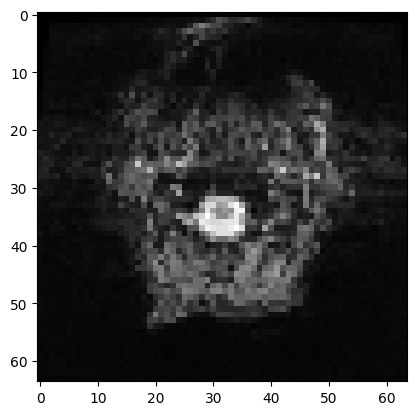

In [34]:
plt.imshow(X[0])

In [35]:
augmented_images = []
augmented_labels = []
for i in range(len(X)):
    image = X[i]
    label = y[i]
    augmented_images.append(image)
    augmented_labels.append(label)
    for _ in range(4):
        aug_image = data_generator.random_transform(image)
        augmented_images.append(aug_image)
        augmented_labels.append(label)


In [36]:
X_augmented = np.array(augmented_images)
y_augmented = np.array(augmented_labels)
X_augmented.shape,y_augmented.shape

((8270, 64, 64, 3), (8270,))

In [39]:
unique_classes_aug, class_counts_aug = np.unique(y_augmented, return_counts=True)
for c, count in zip(unique_classes_aug, class_counts_aug):
    print(f"Class {c}: {count} image")

Class 0: 4825 image
Class 1: 3445 image


In [40]:
print(f"Original data shape: {X.shape}, {y.shape}")
print(f"Augmented data shape: {X_augmented.shape}, {y_augmented.shape}")

Original data shape: (1654, 64, 64, 3), (1654,)
Augmented data shape: (8270, 64, 64, 3), (8270,)


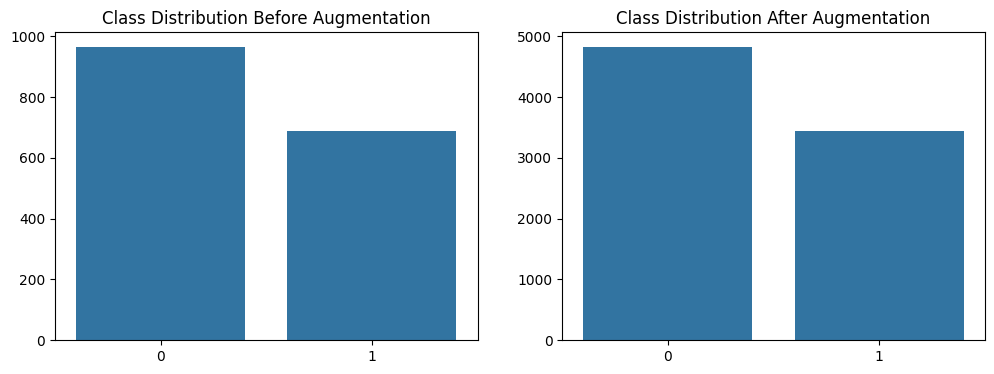

In [18]:
# Calculate the class distributions before and after augmentation
unique_classes, class_counts_before = np.unique(y, return_counts=True)
unique_classes, class_counts_after = np.unique(y_augmented, return_counts=True)

# Plot the class distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(x=unique_classes, y=class_counts_before, ax=ax1)
ax1.set_title("Class Distribution Before Augmentation")
sns.barplot(x=unique_classes, y=class_counts_after, ax=ax2)
ax2.set_title("Class Distribution After Augmentation")
plt.show()

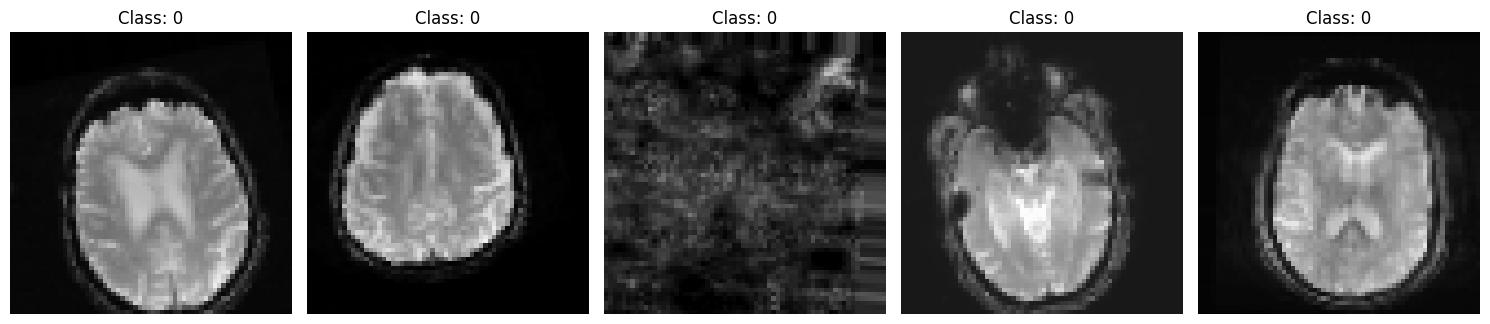

In [19]:
# Display 5 random images from the augmented dataset
indices = np.random.choice(X_augmented.shape[0], size=5, replace=False)
fig, axes = plt.subplots(1, 5, figsize=(15, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_augmented[indices[i]])
    ax.set_title(f"Class: {y_augmented[indices[i]]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# ***Data Shuffleing***

In [ ]:
Y = to_categorical(y_augmented)

x_train, x_test, y_train, y_test = train_test_split(X_augmented, Y, test_size = 0.15, random_state = 98)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)


print('x_test=',x_train.shape)
print('x_test=',x_test.shape)
print('x_val=',x_val.shape)
print('y_test=',y_train.shape)
print('y_test=',y_test.shape)
print('y_val=',y_val.shape)

x_test= (7029, 64, 64, 3)
x_test= (621, 64, 64, 3)
x_val= (620, 64, 64, 3)
y_test= (7029, 2)
y_test= (621, 2)
y_val= (620, 2)


# ***Plot Function***

In [ ]:
def plot_history(network_history):
    history = network_history.history
    losses = history['loss']
    val_losses = history['val_loss']
    accuracies = history['accuracy']
    val_accuracies = history['val_accuracy']

    plt.figure(figsize=(10, 5))
    plt.plot(losses, color='blue', label='Training Loss')
    plt.plot(val_losses, color='orange', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


    plt.figure(figsize=(10, 5))
    plt.plot(accuracies, color='green', label='Training Accuracy')
    plt.plot(val_accuracies, color='red', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()


# ***Model Creating***

In [43]:
tf.keras.backend.clear_session()

def model():
    proposed_model = Sequential()

    proposed_model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))
    proposed_model.add(Conv2D(32, (3, 3), activation='relu'))
    proposed_model.add(MaxPooling2D((2, 2)))
    proposed_model.add(Conv2D(32, (3, 3), activation=
    proposed_model.add(Flatten())
    proposed_model.add(Dense(128, activation='relu'))
    proposed_model.add(Dense(64, activation='relu'))
    proposed_model.add(Dense(2, activation='softmax'))

    # optimizer = Adam(lr=2e-5)
    optimizer = SGD(lr=2e-5)
    # optimizer = keras.optimizers.RMSprop(lr=0.009, rho=0.9, epsilon=1e-08)

    proposed_model.compile(loss ='BinaryCrossentropy', optimizer = optimizer, metrics = ['accuracy'])

    return proposed_model

# ***Model Training & Testing***

Epoch 1/10
220/220 [==============================] - 5s 13ms/step - loss: 0.6812 - accuracy: 0.5763 - val_loss: 0.6677 - val_accuracy: 0.6016
Epoch 2/10
220/220 [==============================] - 2s 8ms/step - loss: 0.6732 - accuracy: 0.5792 - val_loss: 0.6559 - val_accuracy: 0.6016
Epoch 3/10
220/220 [==============================] - 2s 8ms/step - loss: 0.6620 - accuracy: 0.5937 - val_loss: 0.6416 - val_accuracy: 0.6435
Epoch 4/10
220/220 [==============================] - 2s 11ms/step - loss: 0.6530 - accuracy: 0.6034 - val_loss: 0.6508 - val_accuracy: 0.6145
Epoch 5/10
220/220 [==============================] - 2s 11ms/step - loss: 0.6466 - accuracy: 0.6182 - val_loss: 0.6353 - val_accuracy: 0.6258
Epoch 6/10
220/220 [==============================] - 2s 9ms/step - loss: 0.6441 - accuracy: 0.6246 - val_loss: 0.6322 - val_accuracy: 0.6290
Epoch 7/10
220/220 [==============================] - 2s 9ms/step - loss: 0.6361 - accuracy: 0.6344 - val_loss: 0.6304 - val_accuracy: 0.6435
Epo

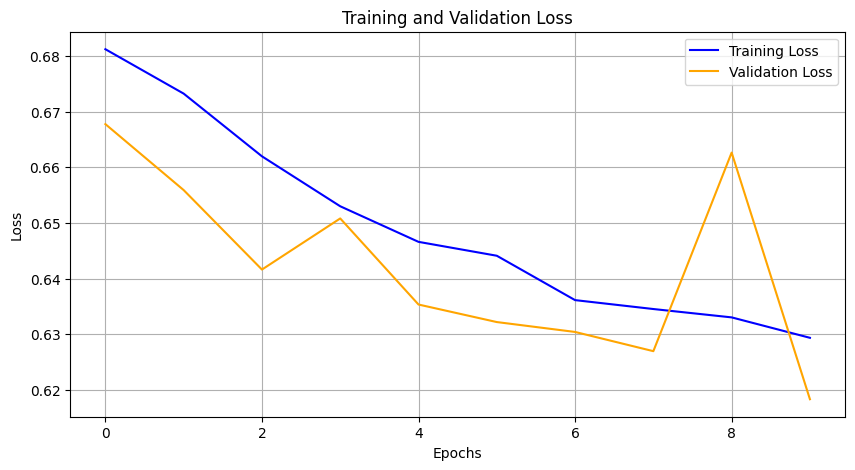

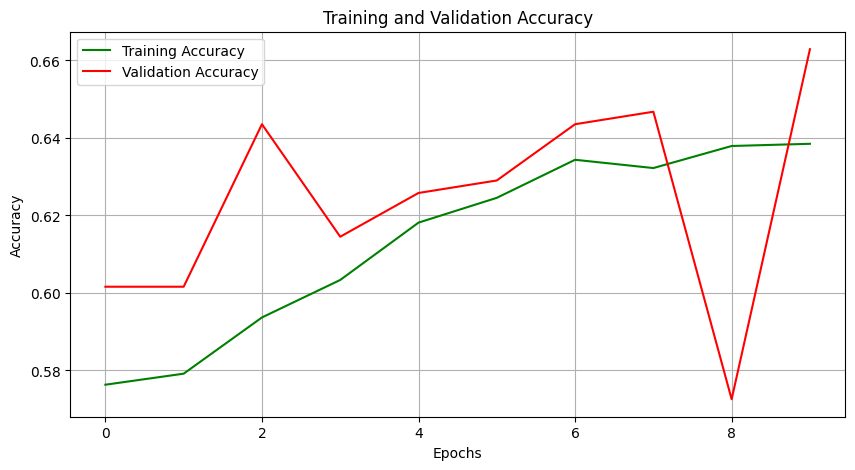

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                   

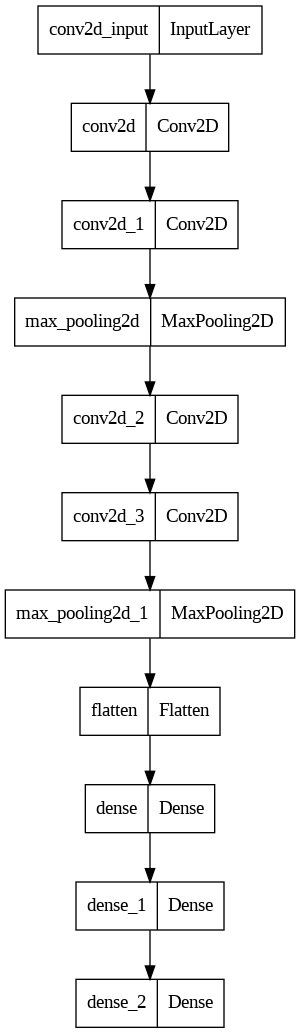

In [45]:
model = model()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
checkpoint_filepath = '/content/drive/My Drive/nwemodel.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True)

network_history = model.fit(x=x_train,
                            y=y_train,
                            epochs=10,
                            validation_data= (x_val, y_val))#,callbacks=[model_checkpoint_callback])
plot_history(network_history)
model.summary()
print('############  Test Data  ############')
test_loss, test_acc = model.evaluate(x_test,y_test)
# prediction = model.predict(x_test)
# prediction = np.argmax(prediction, axis=1)
plot_model(model, to_file='CNN.png')